In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Importar librerías necesarias RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Importar librerías necesarias ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings



In [2]:
# Cargar los DataFrames desde archivos Excel
path_df_location = "../dataset/df_historic_order_demand.xlsx"
df_historic_order_demand = pd.read_excel(path_df_location)

path_df_location = "../dataset/df_location.xlsx"
df_location = pd.read_excel(path_df_location)

path_df_vehicle = "../dataset/df_vehicle.xlsx"
df_vehicle = pd.read_excel(path_df_vehicle)

path_df_orders = "../dataset/df_orders.xlsx"
df_orders = pd.read_excel(path_df_orders)

path_df_distance_km = "../dataset/df_distance_km.xlsx"
df_distance_km = pd.read_excel(path_df_distance_km)

In [3]:
df_orders.head()

,cliente,mes_anio,order_demand
0,Cliente_1,12-2024,909
1,Cliente_2,12-2024,959
2,Cliente_3,12-2024,960
3,Cliente_4,12-2024,980
4,Cliente_5,12-2024,979


In [4]:
# Explorar la estructura del DataFrame
print("Primeras filas del DataFrame:")
print(df_historic_order_demand.head())

print("\nInformación del DataFrame:")
print(df_historic_order_demand.info())

# Verificar si hay valores nulos
print("\nValores nulos por columna:")
print(df_historic_order_demand.isnull().sum())


Primeras filas del DataFrame:
     cliente mes_anio  order_demand
0  Cliente_1  12-2020         857.0
1  Cliente_2  12-2020         941.0
2  Cliente_3  12-2020         878.0
3  Cliente_4  12-2020         949.0
4  Cliente_5  12-2020         932.0

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cliente       980 non-null    object 
 1   mes_anio      980 non-null    object 
 2   order_demand  932 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.1+ KB
None

Valores nulos por columna:
cliente          0
mes_anio         0
order_demand    48
dtype: int64


In [5]:
# Crear una nueva columna 'mes_anio_dia' con los datos en formato datetime
df_historic_order_demand['mes_anio_dia'] = pd.to_datetime(df_historic_order_demand['mes_anio'], format='%m-%Y', errors='coerce')

# Verificar si hay valores nulos en la nueva columna
print("\nValores nulos en 'mes_anio_dia':")
print(df_historic_order_demand['mes_anio_dia'].isnull().sum())


Valores nulos en 'mes_anio_dia':
0


In [6]:
# Verificar si hay duplicados basados en 'cliente' y 'mes_anio'
print("Registros duplicados:")
print(df_historic_order_demand.duplicated(subset=['cliente', 'mes_anio_dia']).sum())

Registros duplicados:
0


In [7]:
# Imprimir una muestra para verificar el resultado
print("Datos preprocesados:")
print(df_historic_order_demand.head())

Datos preprocesados:
     cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_2  12-2020         941.0   2020-12-01
2  Cliente_3  12-2020         878.0   2020-12-01
3  Cliente_4  12-2020         949.0   2020-12-01
4  Cliente_5  12-2020         932.0   2020-12-01


In [8]:
# Ordenar primero por cliente y luego por mes_anio_dia
df_historic_order_demand = df_historic_order_demand.sort_values(by=['cliente', 'mes_anio_dia']).reset_index(drop=True)

# Verificar la estructura después de ordenar
print(df_historic_order_demand.head())  # Muestra las primeras filas para confirmar

     cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_1  01-2021         768.0   2021-01-01
2  Cliente_1  02-2021         635.0   2021-02-01
3  Cliente_1  03-2021         631.0   2021-03-01
4  Cliente_1  04-2021         589.0   2021-04-01


In [9]:
# Mostrar número de valores nulos en la columna 'order_demand'
print("\nValores nulos en 'order_demand':")
print(df_historic_order_demand['order_demand'].isnull().sum())

# Mostrar las filas que contienen valores nulos en 'order_demand'
print("\nFilas con valores nulos en 'order_demand':")
print(df_historic_order_demand[df_historic_order_demand['order_demand'].isnull()])



Valores nulos en 'order_demand':
48

Filas con valores nulos en 'order_demand':
        cliente mes_anio  order_demand mes_anio_dia
55   Cliente_10  06-2021           NaN   2021-06-01
65   Cliente_10  04-2022           NaN   2022-04-01
89   Cliente_10  04-2024           NaN   2024-04-01
92   Cliente_10  07-2024           NaN   2024-07-01
109  Cliente_11  11-2021           NaN   2021-11-01
124  Cliente_11  02-2023           NaN   2023-02-01
128  Cliente_11  06-2023           NaN   2023-06-01
140  Cliente_11  06-2024           NaN   2024-06-01
169  Cliente_12  10-2022           NaN   2022-10-01
173  Cliente_12  02-2023           NaN   2023-02-01
205  Cliente_13  09-2021           NaN   2021-09-01
211  Cliente_13  03-2022           NaN   2022-03-01
229  Cliente_13  09-2023           NaN   2023-09-01
234  Cliente_13  02-2024           NaN   2024-02-01
253  Cliente_14  08-2021           NaN   2021-08-01
254  Cliente_14  09-2021           NaN   2021-09-01
275  Cliente_14  06-2023           

In [10]:
# Sustituir los valores nulos en 'order_demand' por ceros
df_historic_order_demand['order_demand'] = df_historic_order_demand['order_demand'].fillna(0)

# Verificar si quedan valores nulos
print("\nVerificación de valores nulos después de la sustitución:")
print(df_historic_order_demand['order_demand'].isnull().sum())



Verificación de valores nulos después de la sustitución:
0


In [11]:
df_historic_order_demand

,cliente,mes_anio,order_demand,mes_anio_dia
0,Cliente_1,12-2020,857.0,2020-12-01
1,Cliente_1,01-2021,768.0,2021-01-01
2,Cliente_1,02-2021,635.0,2021-02-01
3,Cliente_1,03-2021,631.0,2021-03-01
4,Cliente_1,04-2021,589.0,2021-04-01
...,...,...,...,...
975,Cliente_9,08-2024,662.0,2024-08-01
976,Cliente_9,09-2024,637.0,2024-09-01
977,Cliente_9,10-2024,627.0,2024-10-01
978,Cliente_9,11-2024,613.0,2024-11-01


Dividir los Datos por Cliente


In [12]:
# Crear un diccionario para almacenar los datos por cliente
clientes_data = {}

# Iterar por cada cliente único y guardar sus datos en un DataFrame
for cliente in df_historic_order_demand['cliente'].unique():
    datos_cliente = df_historic_order_demand[df_historic_order_demand['cliente'] == cliente]
    
    # Solo incluir si hay datos válidos para análisis temporal
    if datos_cliente['order_demand'].notnull().sum() > 12:  # Al menos 12 puntos de datos
        clientes_data[cliente] = datos_cliente

# Confirmar cuántos clientes tienen datos suficientes para análisis
print(f"{len(clientes_data)} clientes tienen datos suficientes para análisis temporal.")


20 clientes tienen datos suficientes para análisis temporal.


In [13]:
clientes_data

{'Cliente_1':       cliente mes_anio  order_demand mes_anio_dia
 0   Cliente_1  12-2020         857.0   2020-12-01
 1   Cliente_1  01-2021         768.0   2021-01-01
 2   Cliente_1  02-2021         635.0   2021-02-01
 3   Cliente_1  03-2021         631.0   2021-03-01
 4   Cliente_1  04-2021         589.0   2021-04-01
 5   Cliente_1  05-2021         785.0   2021-05-01
 6   Cliente_1  06-2021         798.0   2021-06-01
 7   Cliente_1  07-2021         599.0   2021-07-01
 8   Cliente_1  08-2021         570.0   2021-08-01
 9   Cliente_1  09-2021         589.0   2021-09-01
 10  Cliente_1  10-2021        1848.0   2021-10-01
 11  Cliente_1  11-2021         597.0   2021-11-01
 12  Cliente_1  12-2021         886.0   2021-12-01
 13  Cliente_1  01-2022         699.0   2022-01-01
 14  Cliente_1  02-2022         609.0   2022-02-01
 15  Cliente_1  03-2022         633.0   2022-03-01
 16  Cliente_1  04-2022         563.0   2022-04-01
 17  Cliente_1  05-2022         816.0   2022-05-01
 18  Cliente_1  06

1. Descomposición de Series Temporales

Descomponiendo serie temporal para Cliente_1...


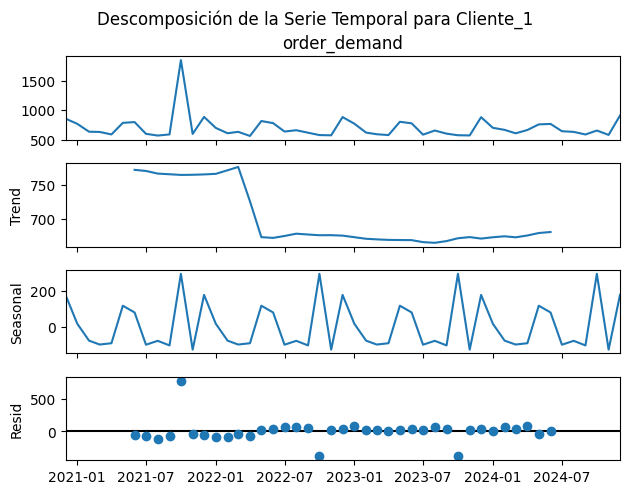

Descomponiendo serie temporal para Cliente_10...


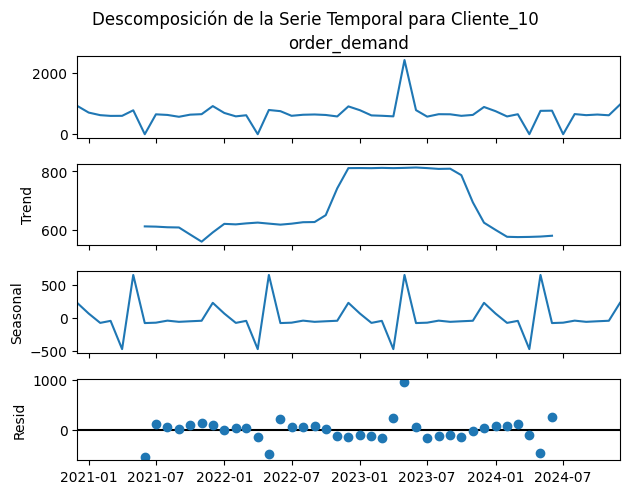

Descomponiendo serie temporal para Cliente_11...


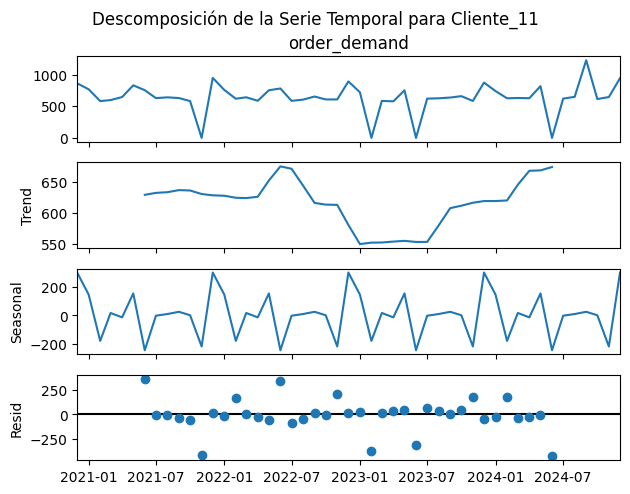

Descomponiendo serie temporal para Cliente_12...


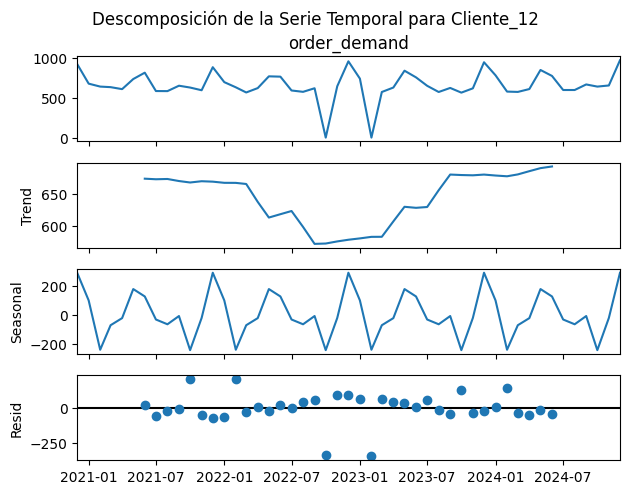

Descomponiendo serie temporal para Cliente_13...


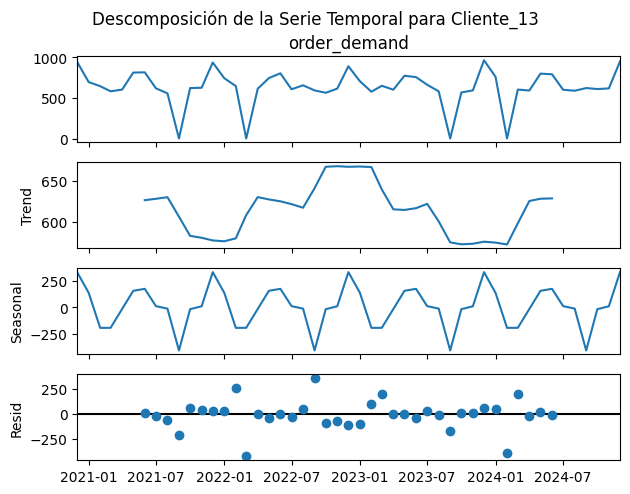

Descomponiendo serie temporal para Cliente_14...


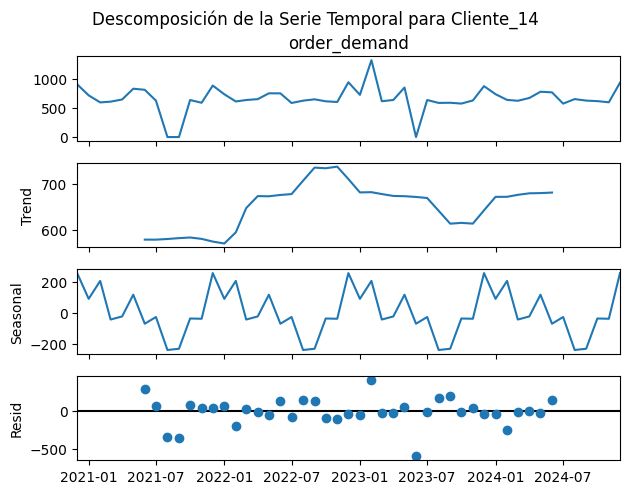

Descomponiendo serie temporal para Cliente_15...


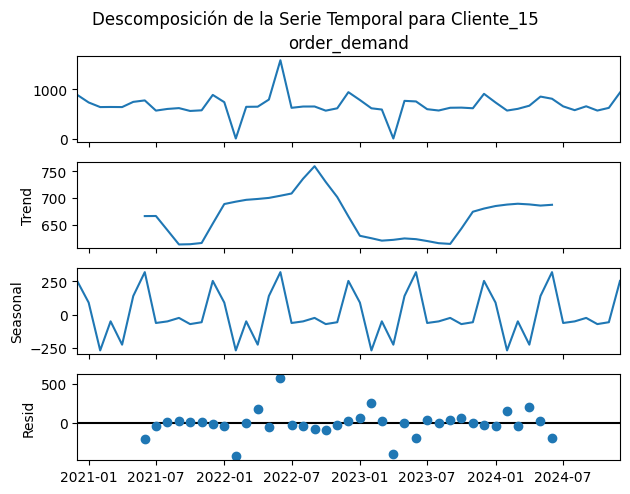

Descomponiendo serie temporal para Cliente_16...


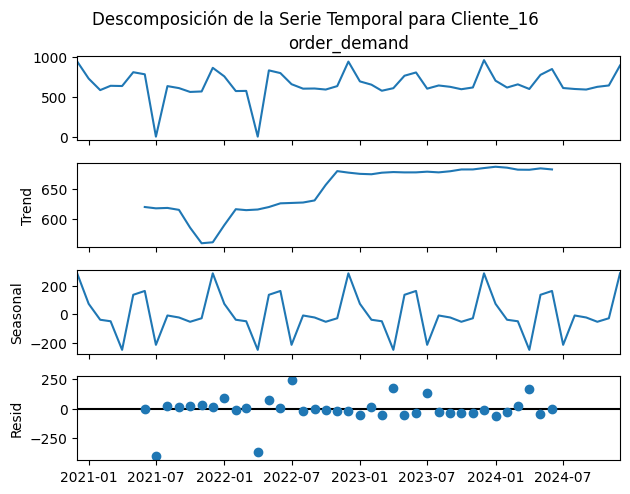

Descomponiendo serie temporal para Cliente_17...


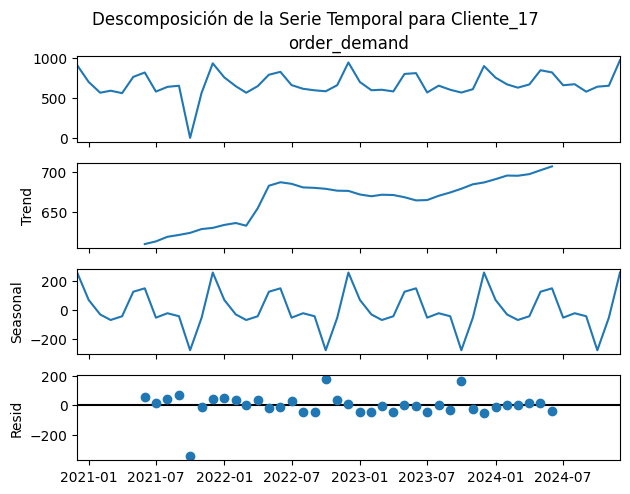

Descomponiendo serie temporal para Cliente_18...


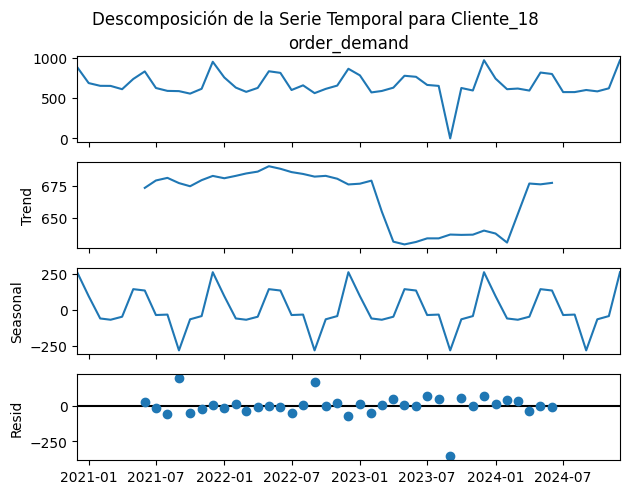

Descomponiendo serie temporal para Cliente_19...


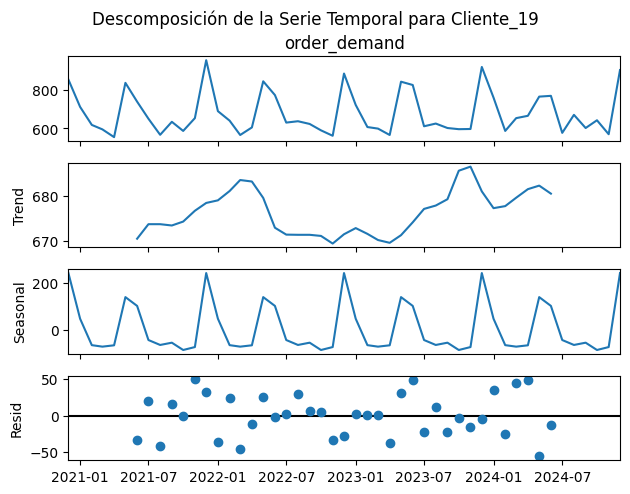

Descomponiendo serie temporal para Cliente_2...


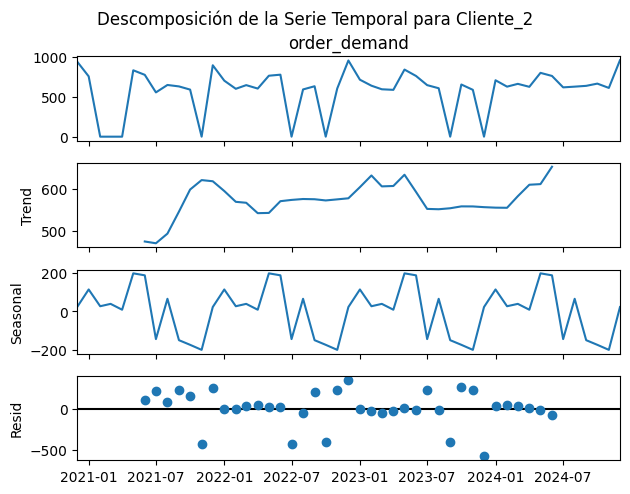

Descomponiendo serie temporal para Cliente_20...


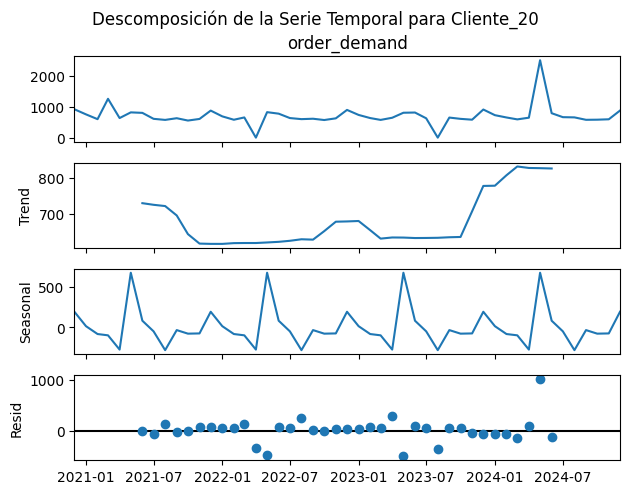

Descomponiendo serie temporal para Cliente_3...


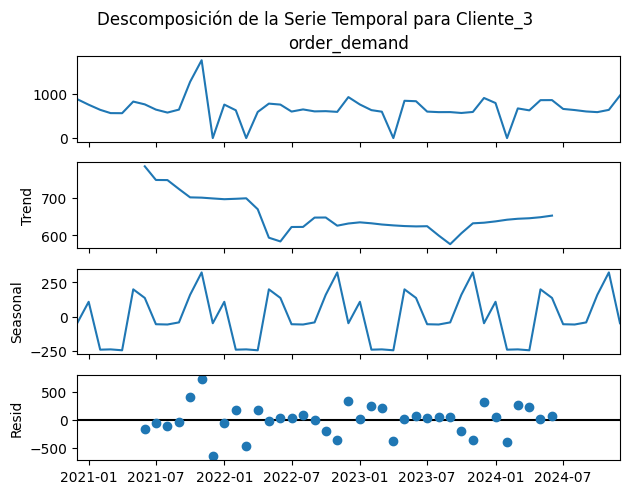

Descomponiendo serie temporal para Cliente_4...


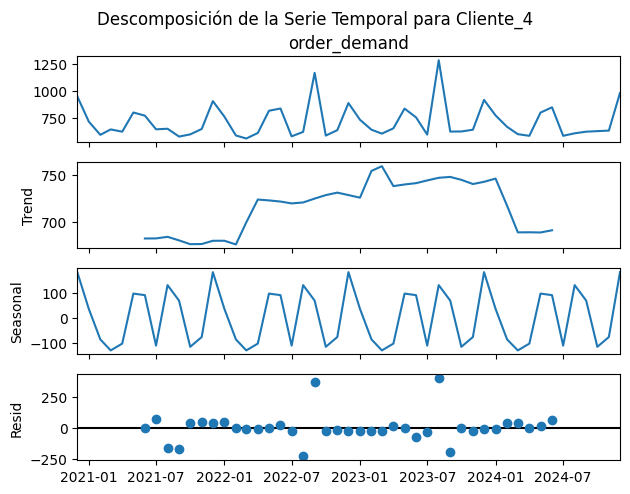

Descomponiendo serie temporal para Cliente_5...


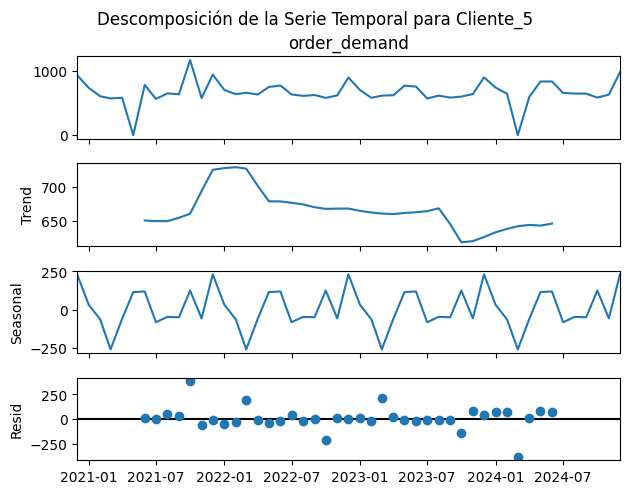

Descomponiendo serie temporal para Cliente_6...


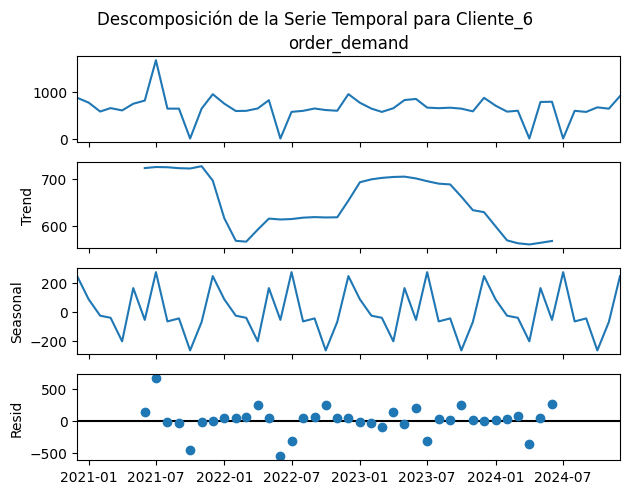

Descomponiendo serie temporal para Cliente_7...


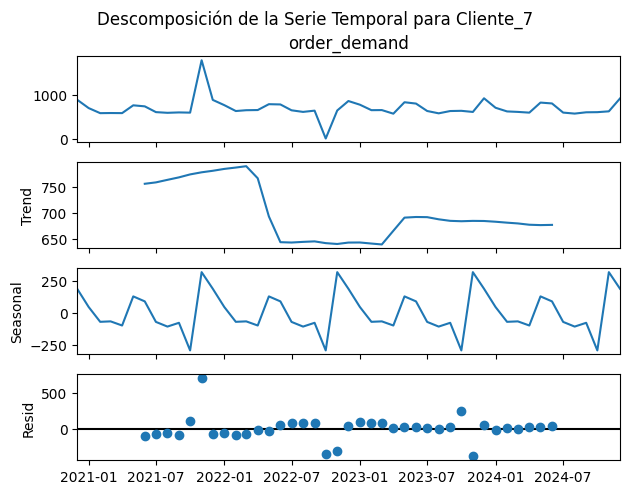

Descomponiendo serie temporal para Cliente_8...


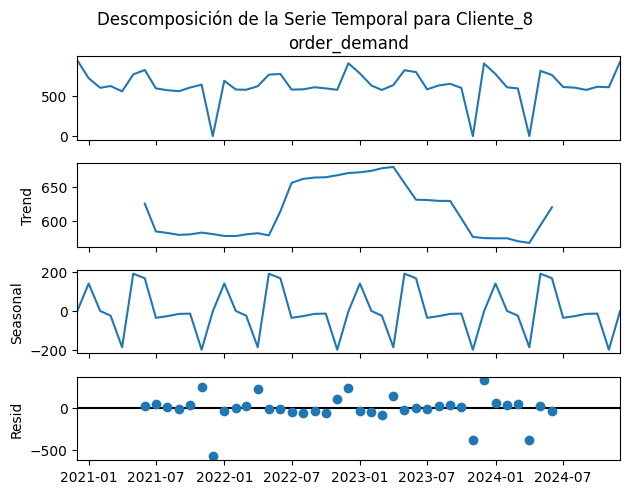

Descomponiendo serie temporal para Cliente_9...


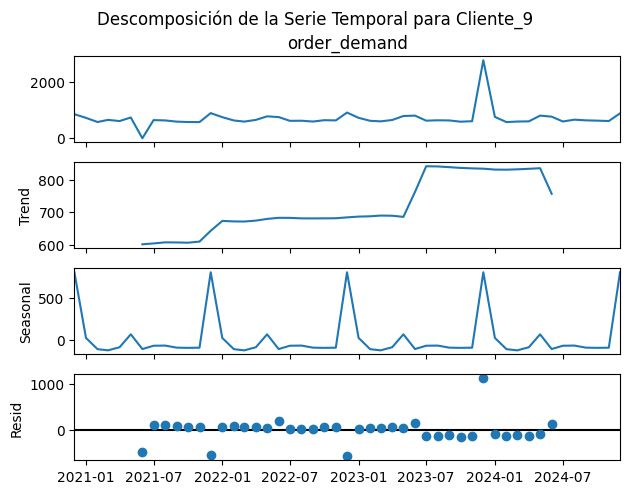

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponer series temporales para cada cliente
for cliente, datos_cliente in clientes_data.items():
    print(f"Descomponiendo serie temporal para {cliente}...")
    datos_cliente = datos_cliente.dropna(subset=['order_demand'])
    
    decomposition = seasonal_decompose(
        datos_cliente.set_index('mes_anio_dia')['order_demand'],
        model='additive',
        period=12
    )
    
    # Graficar los componentes
    decomposition.plot()
    plt.suptitle(f"Descomposición de la Serie Temporal para {cliente}", y=1.02)
    plt.show()


2. Identificar Tendencias Globales

3. Análisis de Estacionalidad por Cliente

4. Evaluación de Estacionalidad y Ruido

Modelo de Predicción con Regresión Random Forest

In [16]:
# Importar las librerías necesarias
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [39]:
# Configurar visualización (opcional)
pd.set_option('display.max_columns', None)

In [40]:
# Paso 1: Preparar los datos
# Verificar valores nulos y llenarlos con 0 si es necesario
df_historic_order_demand['order_demand'] = df_historic_order_demand['order_demand'].fillna(0)

# Crear características temporales a partir de 'mes_anio_dia'
df_historic_order_demand['mes'] = df_historic_order_demand['mes_anio_dia'].dt.month
df_historic_order_demand['anio'] = df_historic_order_demand['mes_anio_dia'].dt.year

# Preparar el conjunto de datos para entrenamiento y prueba
# Seleccionamos las características y el objetivo
X = df_historic_order_demand[['cliente', 'mes', 'anio']]
y = df_historic_order_demand['order_demand']

In [41]:
# Paso 2: Codificación de categorías con OneHotEncoder
# Configurar el OneHotEncoder para la columna 'cliente'
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_clientes = pd.DataFrame(
    encoder.fit_transform(X[['cliente']]),
    columns=encoder.get_feature_names_out(['cliente'])
)

# Concatenar las columnas codificadas con el resto del DataFrame
X_encoded = pd.concat([encoded_clientes, X[['mes', 'anio']].reset_index(drop=True)], axis=1)


In [42]:
# Paso 3: Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Paso 4: Entrenar el modelo con RandomForestRegressor y optimización con GridSearch
# Definir el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Definir los hiperparámetros a buscar
# Actualizar la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras requeridas en un nodo hoja
    'max_features': ['sqrt', 'log2'],  # Características válidas
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],  # Criterios para la función de pérdida
    'bootstrap': [True, False],  # Si se debe usar bootstrap
}

# Configurar el GridSearch con validación cruzada
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Ajustar el GridSearch a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el modelo entrenado
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("Mejores Hiperparámetros:", best_params)


Fitting 3 folds for each of 1728 candidates, totalling 5184 fits
Mejores Hiperparámetros: {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [47]:
# Paso 5: Evaluar el modelo
y_pred = best_rf_model.predict(X_test)

# Calcular métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R2 Score: {r2}")

Mean Absolute Error (MAE): 106.56039540816327
Mean Squared Error (MSE): 62743.9051999681
R2 Score: 0.15201332972838744


*** Los resultados indican que el modelo RandomForestRegressor con los mejores hiperparámetros seleccionados tiene un rendimiento moderado o bajo según las métricas. 

In [50]:
# Paso 6: Predecir para el próximo mes
# Generar un DataFrame para el próximo mes
ultimo_mes = df_historic_order_demand['mes_anio_dia'].max()
proximo_mes = ultimo_mes + pd.DateOffset(months=1)

clientes = df_historic_order_demand['cliente'].unique()
df_proximo_mes = pd.DataFrame({
    'cliente': clientes,
    'mes': proximo_mes.month,
    'anio': proximo_mes.year
})

# Codificar la columna cliente en el nuevo DataFrame
encoded_clientes_next = pd.DataFrame(
    encoder.transform(df_proximo_mes[['cliente']]),
    columns=encoder.get_feature_names_out(['cliente'])
)

# Concatenar las características codificadas con mes y año
X_next = pd.concat([encoded_clientes_next, df_proximo_mes[['mes', 'anio']].reset_index(drop=True)], axis=1)

# Realizar las predicciones
df_proximo_mes['order_demand_pred'] = model.predict(X_next)

# Mostrar las predicciones
print("\nPredicciones para el próximo mes:")
print(df_proximo_mes)

# Exportar las predicciones (opcional)
#df_proximo_mes.to_excel('../output/predicciones_proximo_mes.xlsx', index=False)


Predicciones para el próximo mes:
       cliente  mes  anio  order_demand_pred
0    Cliente_1    1  2025             719.65
1   Cliente_10    1  2025             753.43
2   Cliente_11    1  2025             738.20
3   Cliente_12    1  2025             730.75
4   Cliente_13    1  2025             743.11
5   Cliente_14    1  2025             732.88
6   Cliente_15    1  2025             762.11
7   Cliente_16    1  2025             720.93
8   Cliente_17    1  2025             734.49
9   Cliente_18    1  2025             751.07
10  Cliente_19    1  2025             745.75
11   Cliente_2    1  2025             715.53
12  Cliente_20    1  2025             733.56
13   Cliente_3    1  2025             774.81
14   Cliente_4    1  2025             742.01
15   Cliente_5    1  2025             733.44
16   Cliente_6    1  2025             718.23
17   Cliente_7    1  2025             730.25
18   Cliente_8    1  2025             743.79
19   Cliente_9    1  2025             751.14


Modelo de ARIMA

In [15]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")  # Ignorar advertencias para simplificar la salida

In [19]:
# Paso 1:
# Verificar estructura del DataFrame
print("Primeras filas del DataFrame:")
print(df_historic_order_demand.head())

# Asegurarse de que los datos están ordenados
df_historic_order_demand = df_historic_order_demand.sort_values(by=['cliente', 'mes_anio_dia']).reset_index(drop=True)

Primeras filas del DataFrame:
     cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_1  01-2021         768.0   2021-01-01
2  Cliente_1  02-2021         635.0   2021-02-01
3  Cliente_1  03-2021         631.0   2021-03-01
4  Cliente_1  04-2021         589.0   2021-04-01


In [24]:
# Paso 2: Verificar Estacionariedad para todos los clientes
resultados_estacionariedad = {}

for cliente in df_historic_order_demand['cliente'].unique():
    print(f"\nVerificando estacionariedad para el cliente: {cliente}")
    
    # Filtrar datos por cliente
    data_cliente = df_historic_order_demand[df_historic_order_demand['cliente'] == cliente]
    data_cliente = data_cliente[['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()

    series_to_use = data_cliente['order_demand'].dropna()

    # Prueba ADF (Dickey-Fuller Aumentada)
    result_adf = adfuller(series_to_use)
    print("Resultados de la prueba ADF:")
    print(f"Estadístico ADF: {result_adf[0]}")
    print(f"p-valor: {result_adf[1]}")
    print(f"Valores críticos: {result_adf[4]}")

    # Guardar resultados
    resultados_estacionariedad[cliente] = {
        'es_estacionaria': result_adf[1] <= 0.05,
        'p_valor': result_adf[1],
        'estadistico_adf': result_adf[0],
        'razon': 'p-valor > 0.05, no estacionaria' if result_adf[1] > 0.05 else 'Serie estacionaria'
    }

    # Interpretación
    if result_adf[1] > 0.05:
        print(f"La serie para {cliente} no es estacionaria. Puede requerir diferenciación.")
    else:
        print(f"La serie para {cliente} es estacionaria.")

# Análisis final
print("\nResumen de estacionariedad:")
todas_estacionarias = all(info['es_estacionaria'] for info in resultados_estacionariedad.values())

if todas_estacionarias:
    print("Todas las series son estacionarias.")
else:
    print("Algunas series no son estacionarias:")
    for cliente, info in resultados_estacionariedad.items():
        if not info['es_estacionaria']:
            print(f"- {cliente}: {info['razon']} (p-valor: {info['p_valor']})")





Verificando estacionariedad para el cliente: Cliente_1
Resultados de la prueba ADF:
Estadístico ADF: -7.486202499230385
p-valor: 4.632046187009797e-11
Valores críticos: {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
La serie para Cliente_1 es estacionaria.

Verificando estacionariedad para el cliente: Cliente_10
Resultados de la prueba ADF:
Estadístico ADF: -6.939627059602954
p-valor: 1.0330967693797256e-09
Valores críticos: {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
La serie para Cliente_10 es estacionaria.

Verificando estacionariedad para el cliente: Cliente_11
Resultados de la prueba ADF:
Estadístico ADF: -7.4469354444352165
p-valor: 5.805025706111737e-11
Valores críticos: {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
La serie para Cliente_11 es estacionaria.

Ver

In [ ]:
# Verificar si hay series no estacionarias
if len(series_no_estacionarias) > 0:
    print("Series no estacionarias encontradas:\n")
    
    # Iterar por cada cliente y razones en el diccionario
    for cliente, razones in series_no_estacionarias.items():
        print(f"Cliente: {cliente}")
        print(f"Razones por las que no es estacionaria: {razones}")
        print("-" * 50)
else:
    print("No se encontraron series no estacionarias.")


In [29]:
# Paso 4: Probar combinaciones de parámetros p, d, q
best_models = {}

for cliente in df_historic_order_demand['cliente'].unique():
    print(f"\nProcesando cliente: {cliente}")
    
    # Filtrar datos por cliente
    data_cliente = df_historic_order_demand[df_historic_order_demand['cliente'] == cliente]
    data_cliente = data_cliente[['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()

    series_to_use = data_cliente['order_demand'].dropna()

    best_aic = np.inf
    best_order = None
    best_model = None

    # Probar combinaciones de parámetros
    for p in range(0, 3):
        for d in range(0, 3):
            for q in range(0, 3):
                try:
                    model = ARIMA(series_to_use, order=(p, d, q))
                    model_fit = model.fit()

                    # Evaluar AIC
                    aic = model_fit.aic

                    # Mostrar solo las combinaciones que mejoren el AIC
                    if aic < best_aic:
                        print(f"Mejorado: ARIMA({p}, {d}, {q}) - AIC: {aic}")
                        best_aic = aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except Exception as e:
                    continue

    # Guardar el mejor modelo encontrado
    best_models[cliente] = {
        'model': best_model,
        'order': best_order,
        'aic': best_aic
    }
    print(f"Mejor modelo para {cliente}: ARIMA{best_order} - AIC: {best_aic}")


NameError: name 'modelos_ajustados' is not defined


Evaluando residuos para el cliente: Cliente_1


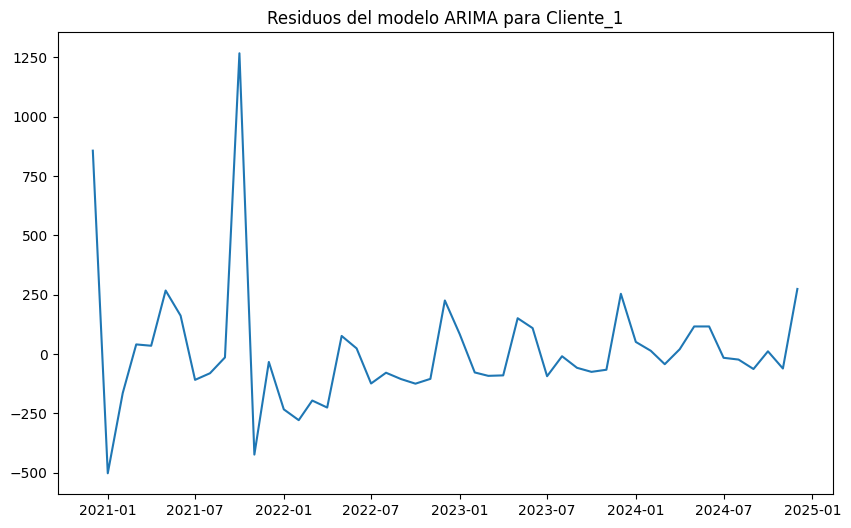


Evaluando residuos para el cliente: Cliente_10


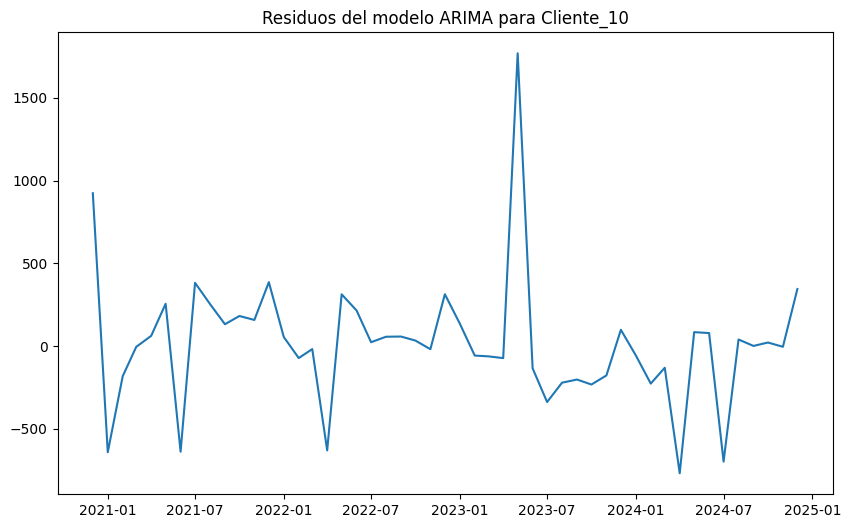


Evaluando residuos para el cliente: Cliente_11


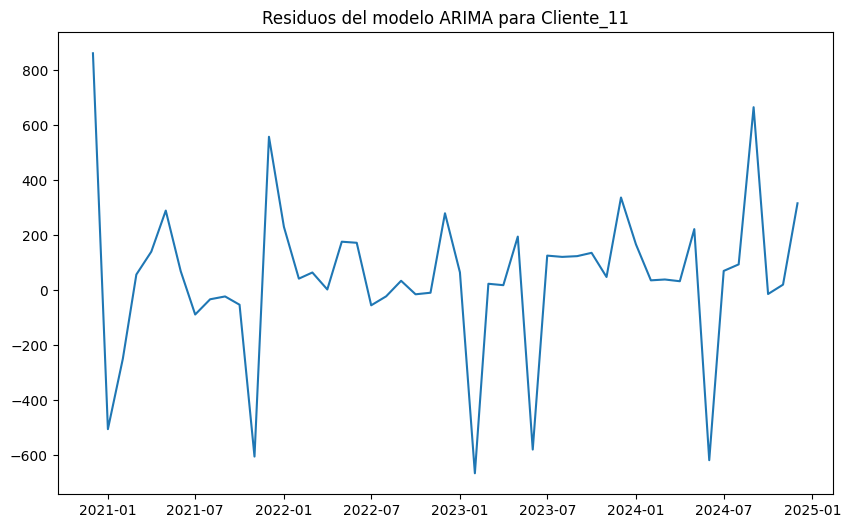


Evaluando residuos para el cliente: Cliente_12


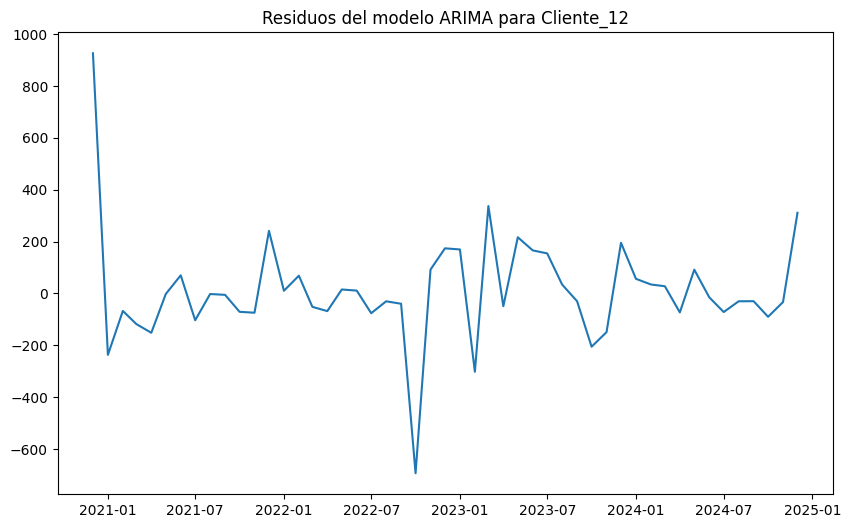


Evaluando residuos para el cliente: Cliente_13


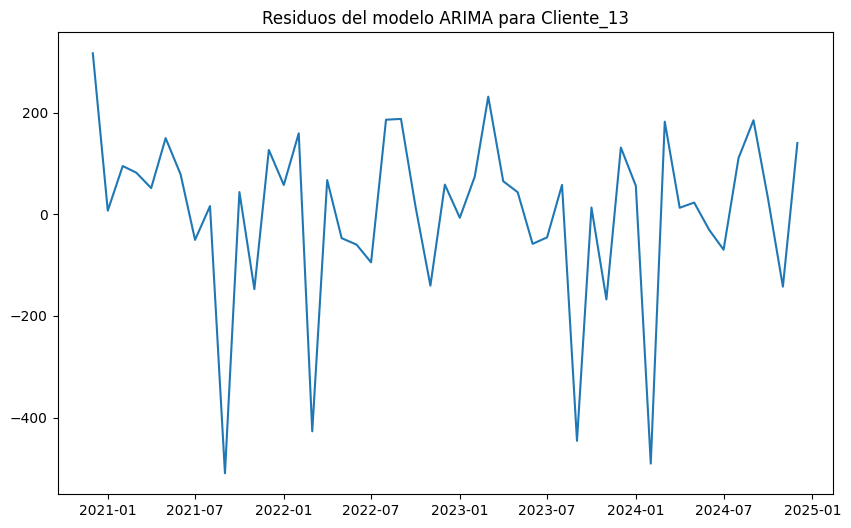


Evaluando residuos para el cliente: Cliente_14


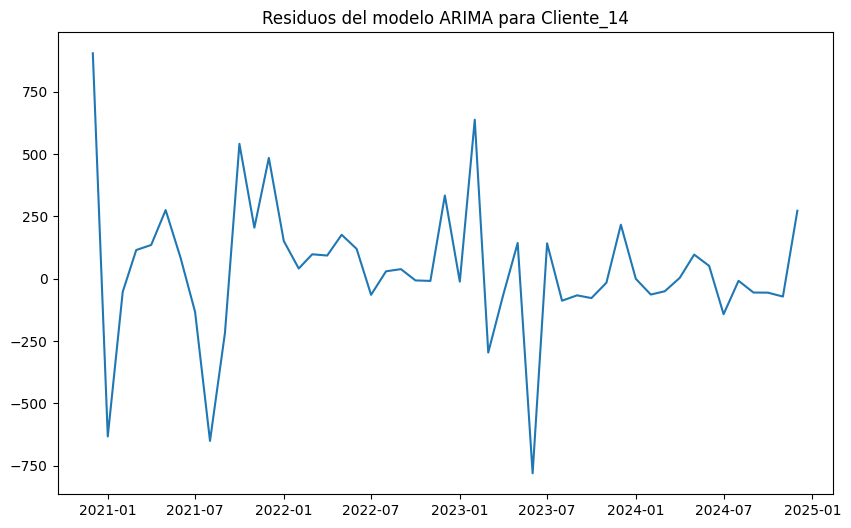


Evaluando residuos para el cliente: Cliente_15


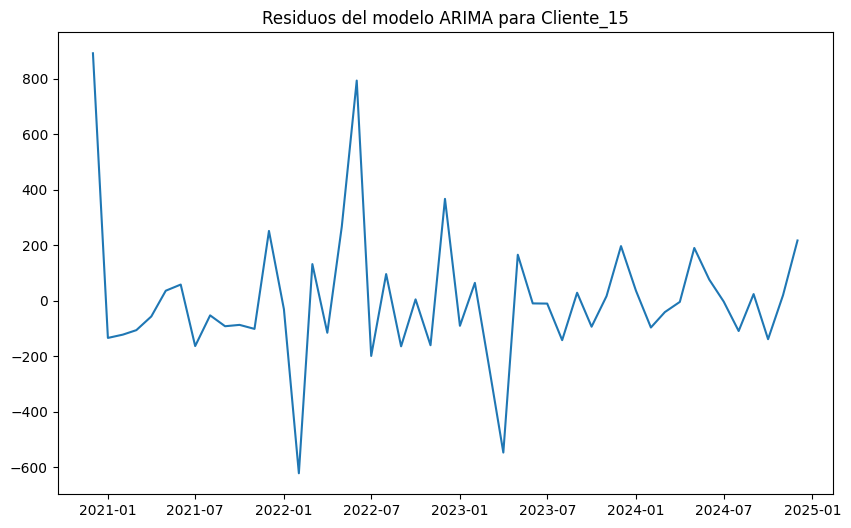


Evaluando residuos para el cliente: Cliente_16


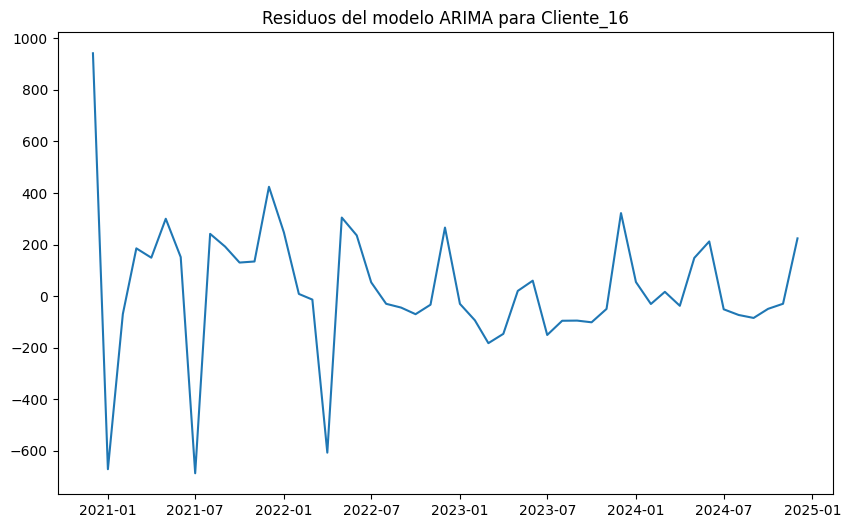


Evaluando residuos para el cliente: Cliente_17


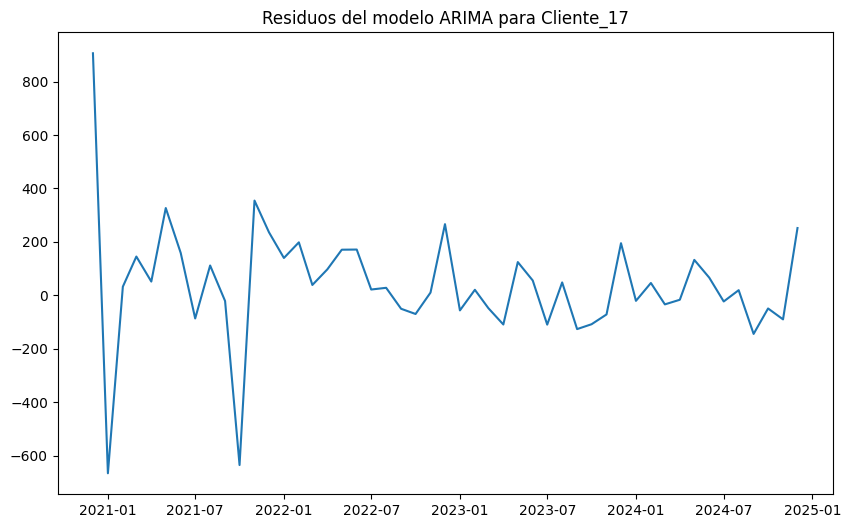


Evaluando residuos para el cliente: Cliente_18


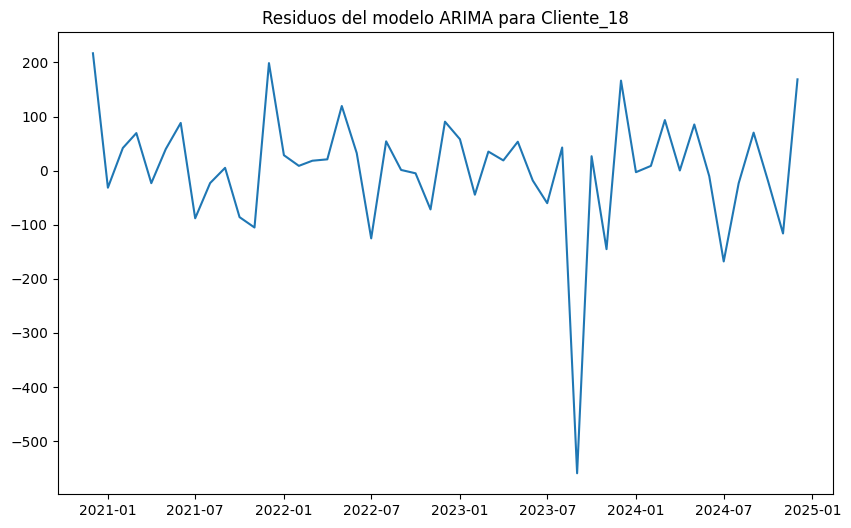


Evaluando residuos para el cliente: Cliente_19


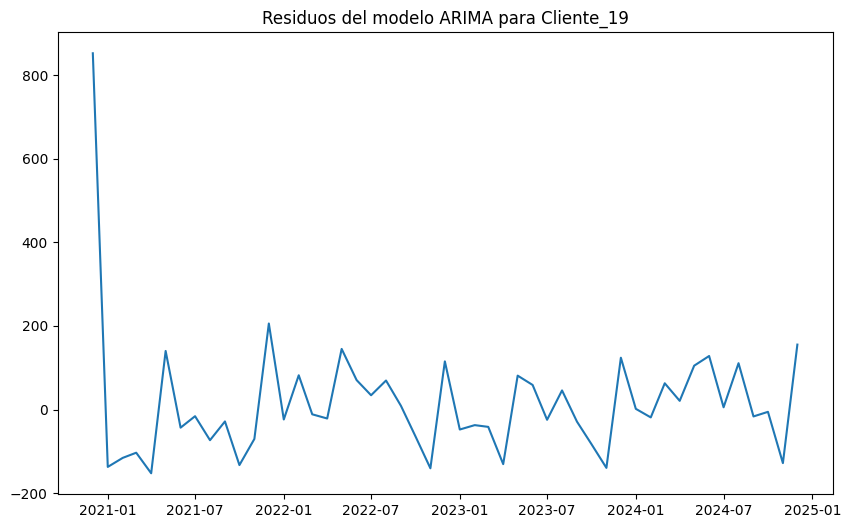


Evaluando residuos para el cliente: Cliente_2


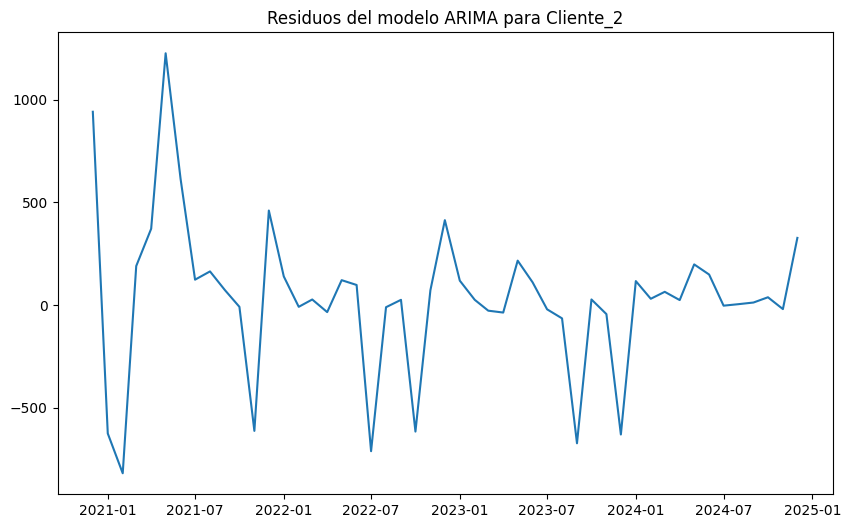


Evaluando residuos para el cliente: Cliente_20


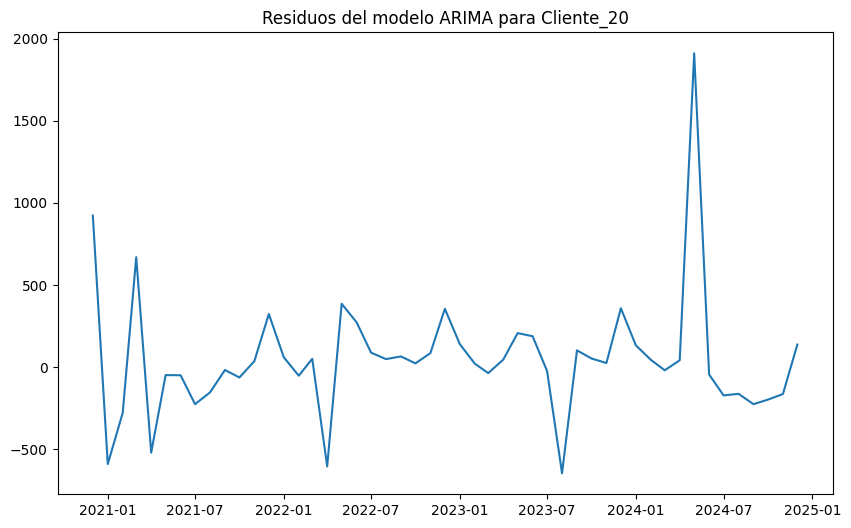


Evaluando residuos para el cliente: Cliente_3


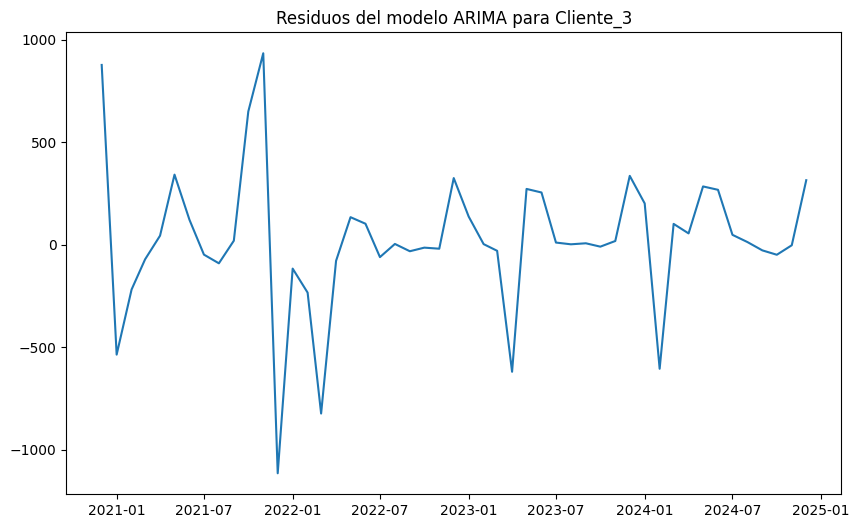


Evaluando residuos para el cliente: Cliente_4


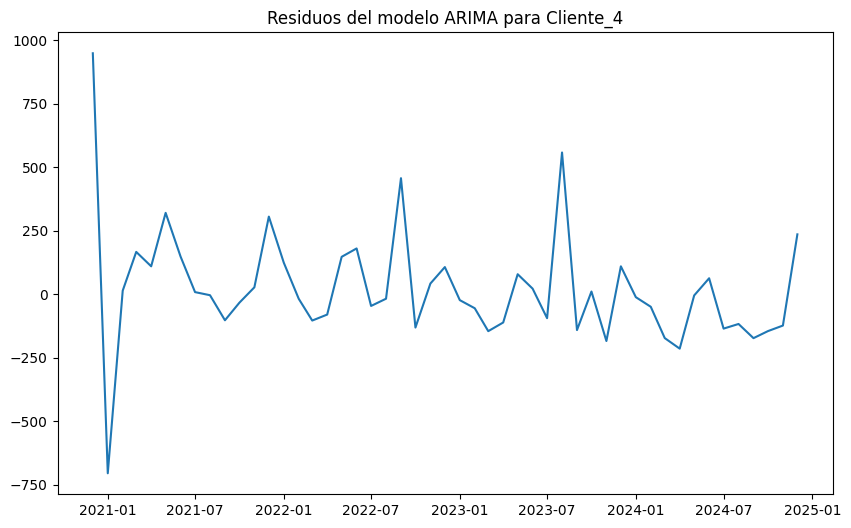


Evaluando residuos para el cliente: Cliente_5


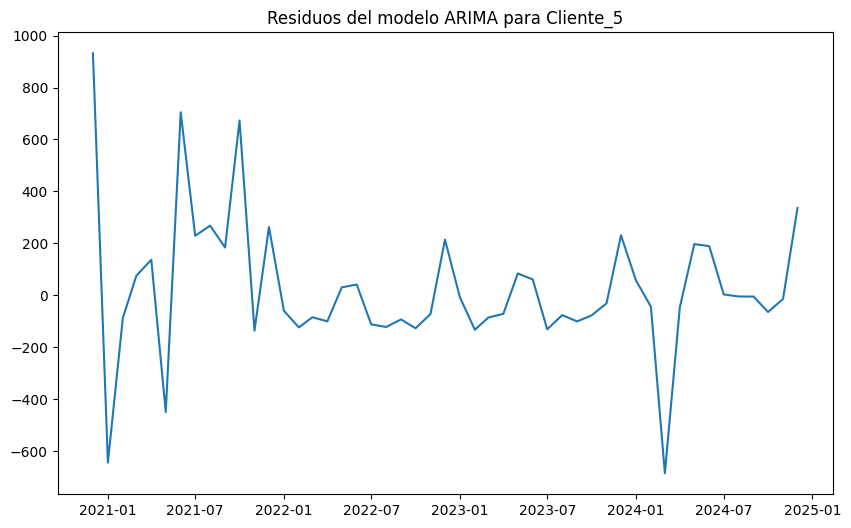


Evaluando residuos para el cliente: Cliente_6


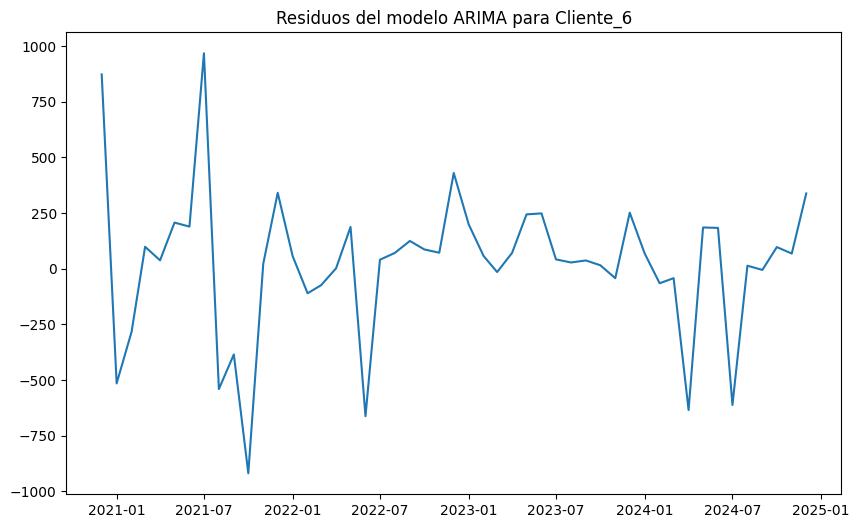


Evaluando residuos para el cliente: Cliente_7


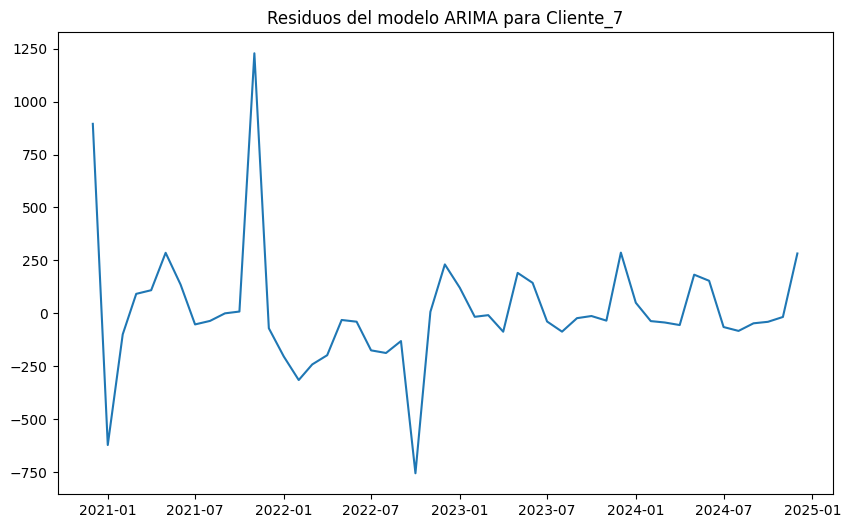


Evaluando residuos para el cliente: Cliente_8


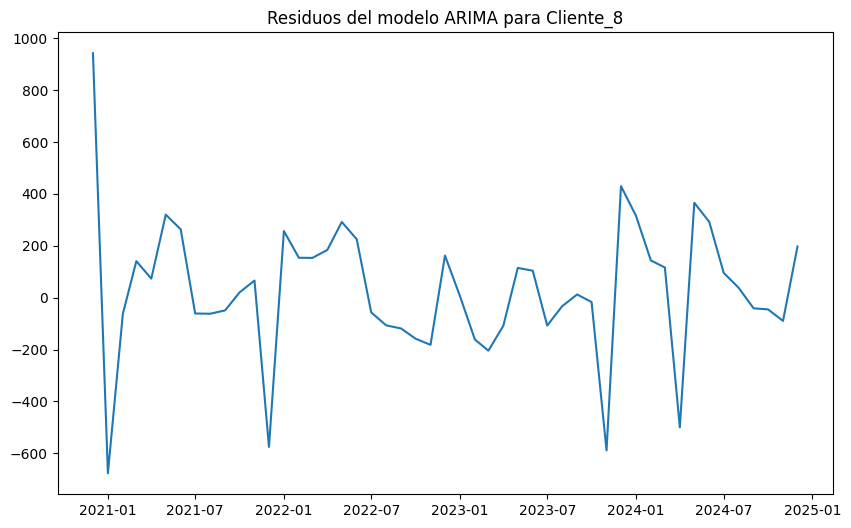


Evaluando residuos para el cliente: Cliente_9


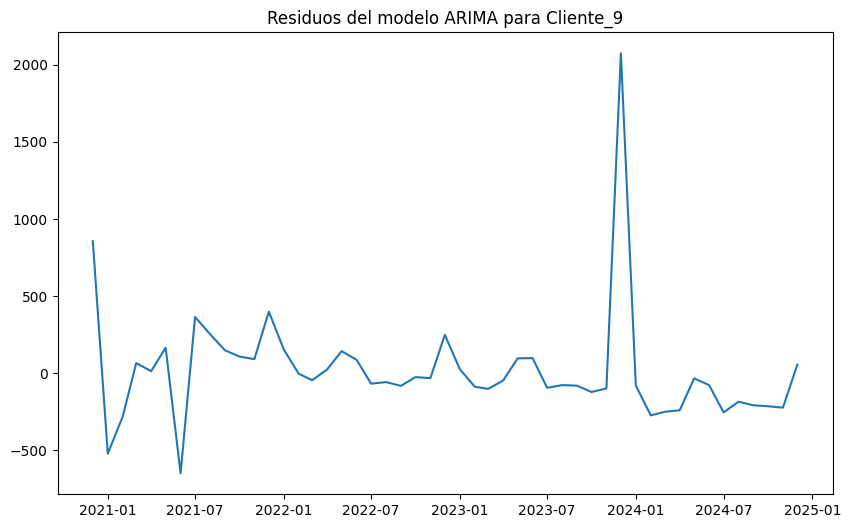

In [25]:
# Paso 4: Evaluación de Residuos
for cliente, model_info in best_models.items():
    if model_info['model']:
        residuals = model_info['model'].resid
        print(f"\nEvaluando residuos para el cliente: {cliente}")

        plt.figure(figsize=(10, 6))
        plt.plot(residuals)
        plt.title(f"Residuos del modelo ARIMA para {cliente}")
        plt.show()
    else:
        print(f"No se encontró un modelo adecuado para el cliente: {cliente}.")


In [26]:
# Paso 5: Predicción para el próximo mes
predicciones = {}

for cliente, model_info in best_models.items():
    if model_info['model']:
        prediccion = model_info['model'].get_forecast(steps=1)
        prediccion_intervalo = prediccion.conf_int()
        prediccion_valor = prediccion.predicted_mean.iloc[0]

        print(f"\nDemanda estimada para {cliente} el próximo mes: {prediccion_valor}")
        print("Intervalo de confianza:")
        print(prediccion_intervalo)

        # Guardar predicción
        predicciones[cliente] = {
            'prediccion': prediccion_valor,
            'intervalo_confianza': prediccion_intervalo
        }
    else:
        print(f"No se encontró un modelo adecuado para {cliente}.")



Demanda estimada para Cliente_1 el próximo mes: 654.1124974010877
Intervalo de confianza:
            lower order_demand  upper order_demand
2025-01-01          254.444798         1053.780196

Demanda estimada para Cliente_10 el próximo mes: 658.9344060447742
Intervalo de confianza:
            lower order_demand  upper order_demand
2025-01-01          -33.782637         1351.651449

Demanda estimada para Cliente_11 el próximo mes: 656.5078488070179
Intervalo de confianza:
            lower order_demand  upper order_demand
2025-01-01          180.088348          1132.92735

Demanda estimada para Cliente_12 el próximo mes: 691.563267650842
Intervalo de confianza:
            lower order_demand  upper order_demand
2025-01-01          374.558573         1008.567962

Demanda estimada para Cliente_13 el próximo mes: 677.634602046357
Intervalo de confianza:
            lower order_demand  upper order_demand
2025-01-01          353.762014          1001.50719

Demanda estimada para Cliente_14


Aquí están algunas técnicas que podríamos considerar:

Series Temporales (como ARIMA, SARIMA): Estos modelos son útiles para datos con tendencias y patrones estacionales, que pueden ser comunes en datos de pedidos.

Modelos de Regresión: Podemos usar regresiones lineales o múltiples si la demanda está influenciada por múltiples factores externos o internos que están representados en los datos.

Machine Learning (como Random Forests, Gradient Boosting Machines): Estos modelos pueden capturar complejidades no lineales y interacciones entre variables que los modelos más simples pueden pasar por alto.